In [1]:
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
import random
import tacco as tc
random.seed(0)

import sys
import pareto_interactions_py as P
import altair_saver

save = False
outdir = '../output/'

# Slide-seq data analysis
1. Compute correlation of task and spatial distances based on *in-silico* dissection of the tissue
2. Plot expression of ligand receptor genes

In [2]:
dirname = '../datasets/'
puck_num = 20

# zoom-in region
xmin = 3500
xmax = 5000

def get_zoomed_flipped_adata(adata, subset=True):
    if subset:
        sadata = adata[(adata.obs['x'] > xmin) & (adata.obs['x'] < xmax)].copy()
    else:
        sadata = adata.copy()
    sadata.obs['x_org'] = sadata.obs['x'].copy()
    sadata.obs['y_org'] = sadata.obs['y'].copy()
    sadata.obs['x'] = sadata.obs['y_org']
    sadata.obs['y'] = -sadata.obs['x_org']
    return sadata

In [3]:
# read data
annotation_key = 'types'
fname = os.path.join(dirname, f'2020-09-14_Puck_200701_{puck_num}.h5ad')
types = pd.read_csv(os.path.join(dirname, f'2020-09-14_Puck_200701_{puck_num}_all_ct.csv'), index_col=0)
regions = pd.read_csv(os.path.join(dirname, f'2020-09-14_Puck_200701_{puck_num}_all_region.csv'), index_col=0)

adata = sc.read_h5ad(fname)
adata = adata[types.index]
adata.obsm[annotation_key] = types
adata.obs = pd.concat((adata.obs, regions), 1)

/var/folders/8y/cpqrd46n7ml80f139vjz9l240000gn/T/ipykernel_30503/2264280130.py:10: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  adata.obs = pd.concat((adata.obs, regions), 1)


## Correlation of task and spatial distances based on *in-silico* dissection of the tissue

To be comparable to the enterocyte data, we section the tissue into 6 bins according to their distance from the apical plasma membrane layer.

/var/folders/8y/cpqrd46n7ml80f139vjz9l240000gn/T/ipykernel_30503/4148846118.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  rdata.obs['region'] = rdata.obs['region'].astype('category')


annotation_distance: The argument `distance_key` is `None`, meaning that the distance which is now calculated on the fly will not be saved. Providing a precalculated distance saves time in multiple calls to this function.
calculating distance for sample 1/1


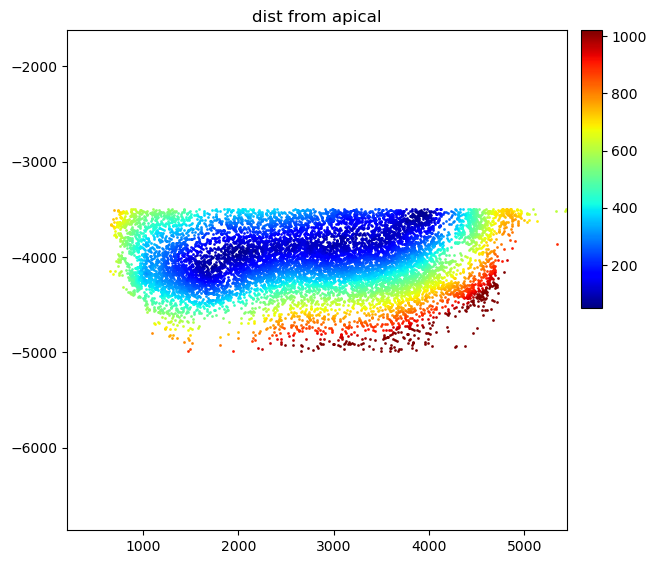

In [4]:
# compute distance from apical plasma membrane
rdata = adata[regions.index]
rdata.obs['region'] = rdata.obs['region'].astype('category')
# sdata = get_zoomed_flipped_adata(rdata)
# tc.pl.scatter(sdata, 'region');

tc.tl.annotation_coordinate(rdata, annotation_key='region', result_key='region_dist', max_distance=1000, delta_distance=20, sparse=False);
rdata.obs['dist from apical'] = rdata.obsm['region_dist']['region_2'] # region_2 corresponds to apical plasma membrane

sdata = get_zoomed_flipped_adata(rdata)
tc.pl.scatter(sdata,'dist from apical', cmap='jet');


In [5]:
# read fibroblasts task
locs_org = pd.read_csv(os.path.join(dirname, f'colonFibP{puck_num}SpatialPos.csv'), index_col=0)
tasks_org = pd.read_csv(os.path.join(dirname, f'colonFibP{puck_num}TaskPos.csv'), header=None)
tasks_org.index = locs_org.index

frdata = rdata[list(set(rdata.obs_names).intersection(locs_org.index))]
frdata.obsm['tasks'] = tasks_org.loc[frdata.obs_names]
# sdata = get_zoomed_flipped_adata(frdata)
# tc.pl.scatter(sdata,'dist from apical', cmap='jet', joint=True, title='subset to fibroblasts');
# tc.pl.scatter(sdata,'tasks', joint=True, title='colored by tasks');

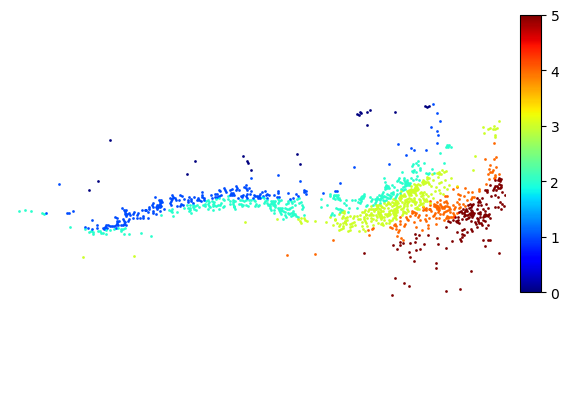

In [6]:
# partition the tissue to physical sections

nbins = 6
frdata.obs['cut from apical'] = pd.cut(frdata.obs['dist from apical'], bins=nbins, labels=np.arange(nbins))

frdata.obs['in silico dissection'] = frdata.obs['cut from apical'].astype(int)
sdata = get_zoomed_flipped_adata(frdata)

fig, ax = plt.subplots(1,1)
tc.pl.scatter(sdata,'in silico dissection', cmap='jet', noticks=True, joint=True, ax=ax);
ax.axis('off')
ax.set_title('', fontsize=25)
if save:
    plt.savefig(os.path.join(outdir, 'colonFib20_physical_dissection_.png'))


In [7]:
# compute correlation of task distances and physical distances
G = frdata.obsm['tasks'].values
L = frdata.obs[['cut from apical']].values

n_shuff = 1000
comp_null = True

p = P.pl.plot_task_phys(G, L, comp_null=comp_null, n_shuff=n_shuff, tit='')

p.display()
if save:
    p.save(os.path.join(f'colonFibP{puck_num}_physical_dissection.png'), scale_factor=5)


corr: 0.02
pval: 0.04700


/Users/nomo/opt/miniconda3/envs/pareto_env/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

## Plot prominent signalling genes

Plotting signalling genes with respect to tissue regions:

/Users/nomo/opt/miniconda3/envs/pareto_env/lib/python3.10/site-packages/tacco/plots/_plots.py:624: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum(axis=-1)[...,None]
/Users/nomo/opt/miniconda3/envs/pareto_env/lib/python3.10/site-packages/tacco/plots/_plots.py:624: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum(axis=-1)[...,None]
/Users/nomo/opt/miniconda3/envs/pareto_env/lib/python3.10/site-packages/tacco/plots/_plots.py:624: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum(axis=-1)[...,None]
/Users/nomo/opt/miniconda3/envs/pareto_env/lib/python3.10/site-packages/tacco/plots/_plots.py:624: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum(axis=-1)[...,None]
/Users/nomo/opt/miniconda3/envs/pareto_env/lib/python3.10/site-packages/tacco/plots/_plots.py:624: RuntimeWarning: invalid value encountered in divide
  weights = weights / weights.sum

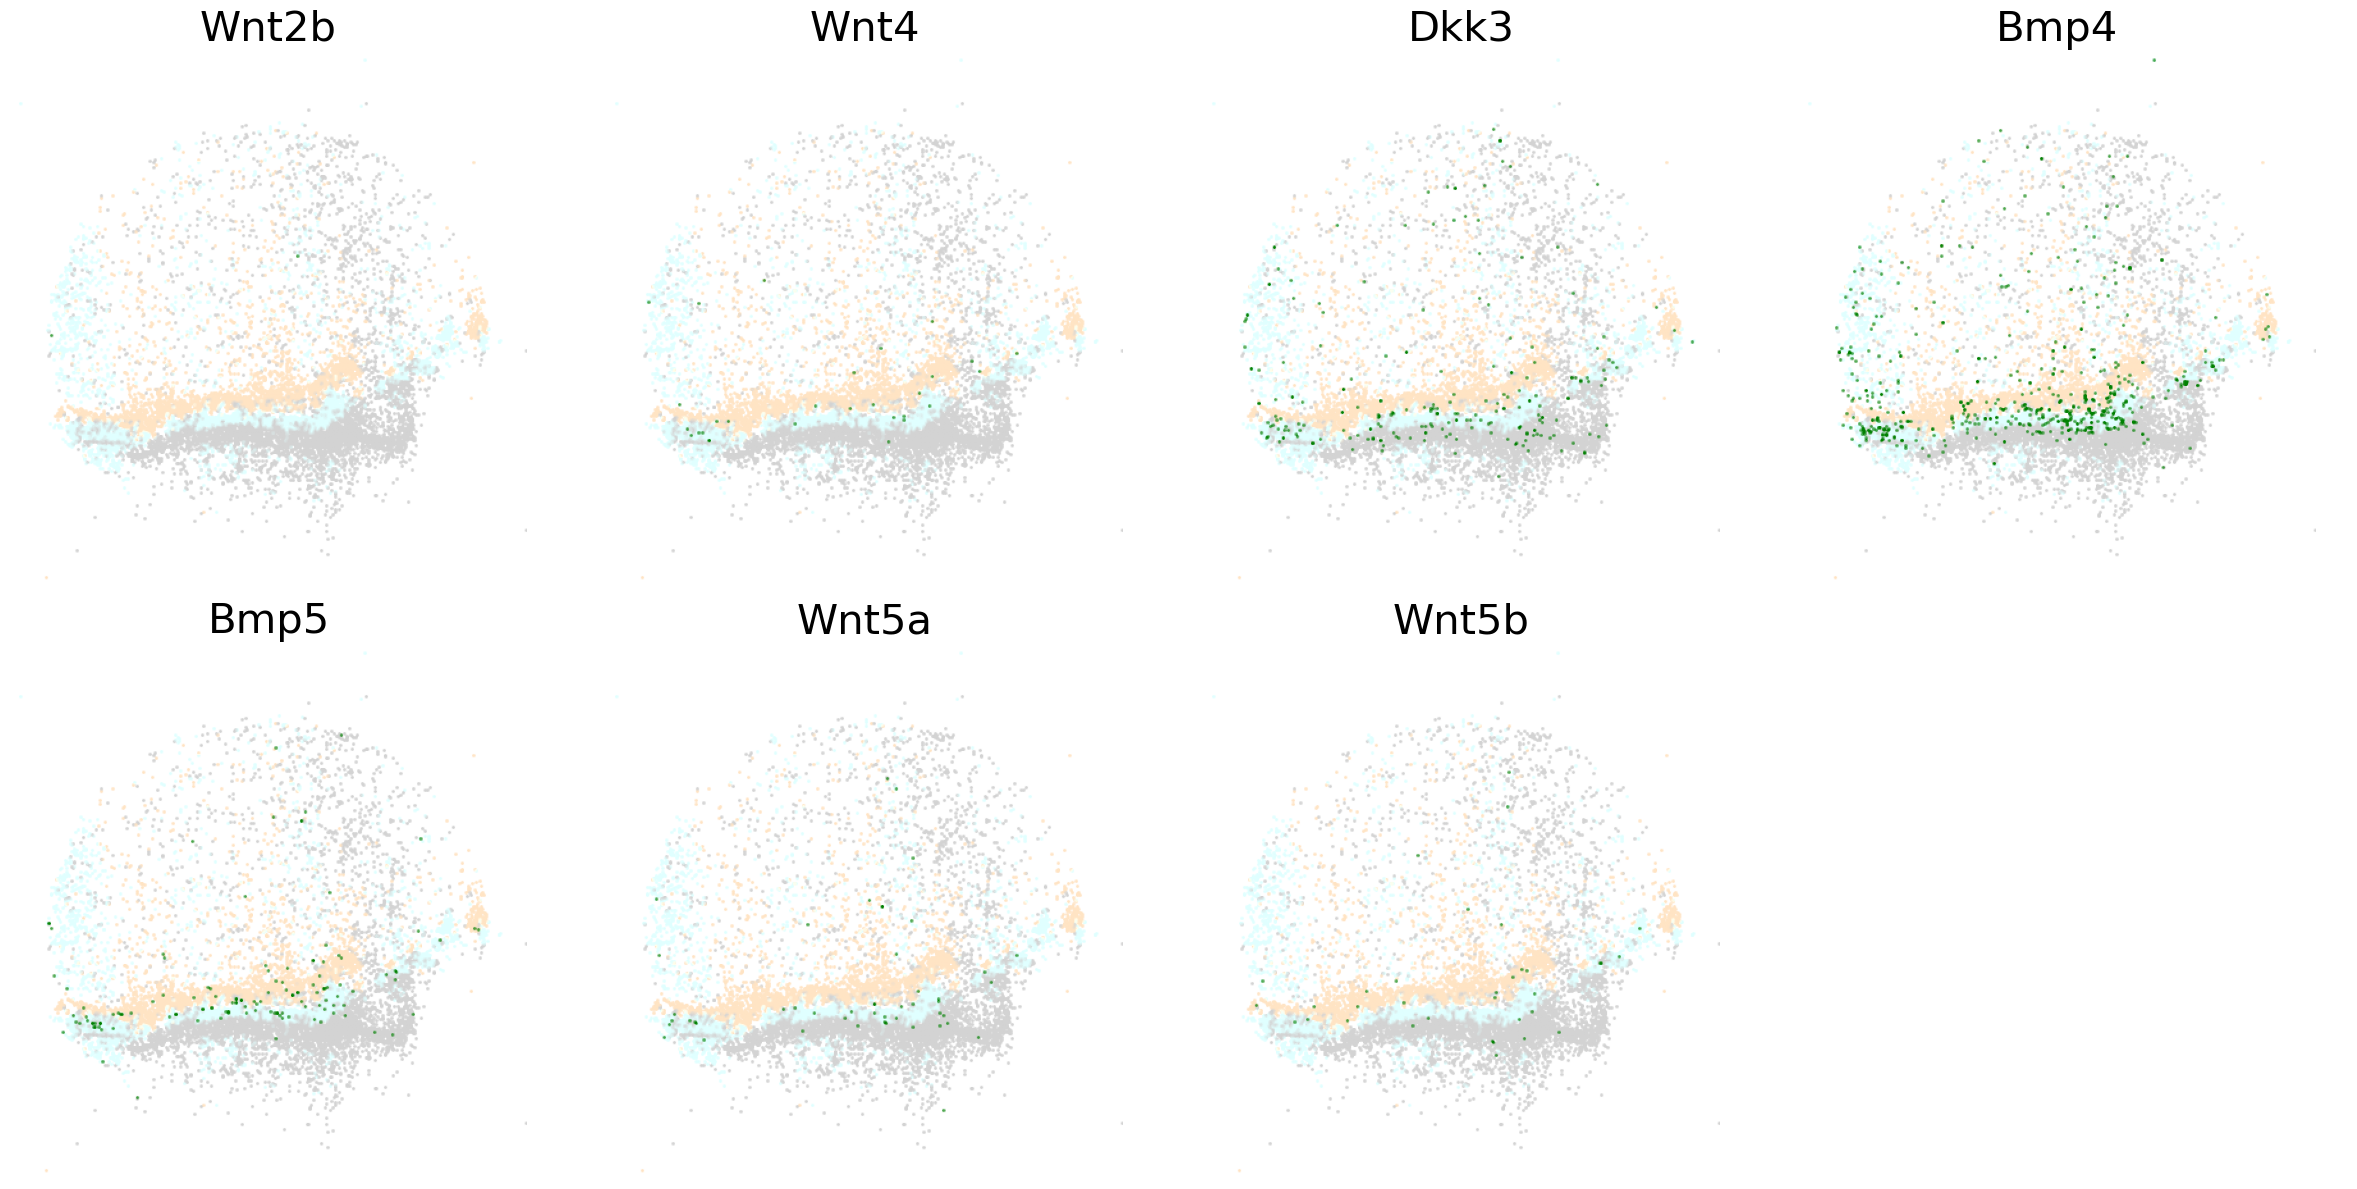

In [8]:
signaling_genes = ['Wnt2b', 'Wnt4','Dkk3','Bmp4', 'Bmp5', 'Wnt5a', 'Wnt5b', ]

region_colors = {'null': 'white',
                'apical plasma membrane': 'bisque',
                 'deep crypt': 'lightcyan',
                 'muscularis': 'lightgray',}
nregions = len(region_colors)

kwargs_pl = {'point_size': 3, 
             'noticks': True, 
             'axes_labels': ['X','Y'], 
             'joint': True, 
               }

kwargs_region = {'keys': 'region_name',
                 'colors': region_colors}
sg_col = 'signaling gene'
kwargs_sg = {'keys': sg_col, 
             'colors': {'signaling gene': 'green'}, 
             'cmap_vmin_vmax': [0,0.5],
            'legend': False}


nrow = 2
ncol = int(np.ceil(len(signaling_genes) / nrow))
fig, axs = plt.subplots(nrow, ncol, figsize=(6*ncol, 6*nrow))

sdata = get_zoomed_flipped_adata(rdata, subset=False)

for isg, sg in enumerate(signaling_genes):
    ax = axs[int(np.divide(isg, ncol)), int(np.mod(isg, ncol))]
    ax.axis('off')
    sdata.obs[sg_col] = np.log1p(sdata[:, sg].to_df())
    tc.pl.scatter(sdata, ax=ax, **kwargs_region, **kwargs_pl, legend=False);
    tc.pl.scatter(sdata, ax=ax, **kwargs_sg, **kwargs_pl);
    ax.set_title(sg, fontsize=30);

axs[-1,-1].axis('off')
plt.tight_layout()

if save:
    plt.savefig(os.path.join(outdir, 'signaling_genes_sub.png'), dpi=300)

